<h1> Historical Deutscher Wetterdienst (DWD) Weather Data for Germany </h1>

<h2> Install and Import </h2>

In [30]:
from pathlib import Path
import sys
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src import eda_utils
from src import plotting_utils
from src import config as cfg
from src import dwd_utils
from src.config import RAW  
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import math


First we create a data frame covering ten representative German cities. Representative as in: They are distributed throughout the territory, they include the biggest cities, and every TSO control area is represented at least twice.

In [ ]:
DE_cities_df = pd.DataFrame([
    {"city_id": "DE_BE_50H_1", "city_name": "Berlin",    "state": "DE_BE", "latitude": 52.5200, "longitude": 13.4050, "TSO": "50Hertz"},
    {"city_id": "DE_HH_50H_1", "city_name": "Hamburg",   "state": "DE_HH", "latitude": 53.5511, "longitude": 9.9937,  "TSO": "50Hertz"},
    {"city_id": "DE_HE_AMP_1", "city_name": "Frankfurt", "state": "DE_HE", "latitude": 50.1109, "longitude": 8.6821,  "TSO": "Amprion"},
    {"city_id": "DE_NW_AMP_1", "city_name": "Cologne",   "state": "DE_NW", "latitude": 50.9375, "longitude": 6.9603,  "TSO": "Amprion"},
    {"city_id": "DE_BY_AMP_1", "city_name": "Augsburg",  "state": "DE_BY", "latitude": 48.3705, "longitude": 10.8978, "TSO": "Amprion"},  # NEW
    {"city_id": "DE_BW_TNB_1", "city_name": "Stuttgart", "state": "DE_BW", "latitude": 48.7758, "longitude": 9.1829,  "TSO": "TransnetBW"},
    {"city_id": "DE_BY_TEN_1", "city_name": "Munich",    "state": "DE_BY", "latitude": 48.1351, "longitude": 11.5820, "TSO": "TenneT"},
    {"city_id": "DE_SN_50H_1", "city_name": "Leipzig",   "state": "DE_SN", "latitude": 51.3397, "longitude": 12.3731, "TSO": "50Hertz"},
    {"city_id": "DE_SH_TEN_1", "city_name": "Kiel",      "state": "DE_SH", "latitude": 54.3233, "longitude": 10.1228, "TSO": "TenneT"},
    {"city_id": "DE_BW_TNB_2", "city_name": "Freiburg",  "state": "DE_BW", "latitude": 47.9990, "longitude": 7.8421,  "TSO": "TransnetBW"},
    {"city_id": "DE_SN_50H_2", "city_name": "Dresden",   "state": "DE_SN", "latitude": 51.0504, "longitude": 13.7373, "TSO": "50Hertz"}
])
display(DE_cities_df)

,city_id,city_name,state,latitude,longitude,TSO
0,DE_BE_50H_1,Berlin,DE_BE,52.5200,13.4050,50Hertz
1,DE_HH_50H_1,Hamburg,DE_HH,53.5511,9.9937,50Hertz
2,DE_HE_AMP_1,Frankfurt,DE_HE,50.1109,8.6821,Amprion
3,DE_NW_AMP_1,Cologne,DE_NW,50.9375,6.9603,Amprion
4,DE_BY_AMP_1,Augsburg,DE_BY,48.3705,10.8978,Amprion
5,DE_BW_TNB_1,Stuttgart,DE_BW,48.7758,9.1829,TransnetBW
6,DE_BY_TEN_1,Munich,DE_BY,48.1351,11.5820,TenneT
7,DE_SN_50H_1,Leipzig,DE_SN,51.3397,12.3731,50Hertz
8,DE_SH_TEN_1,Kiel,DE_SH,54.3233,10.1228,TenneT
9,DE_BW_TNB_2,Freiburg,DE_BW,47.9990,7.8421,TransnetBW


<h4> Weather stations </h4>

We retrieve historical data sets from the DWD opendata, belonging to weather stations at or near to one of our eleven cities, picked from the [listed weather stations of the DWD](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/TU_Stundenwerte_Beschreibung_Stationen.txt).

| City       | Station ID | Station Name             | State | Latitude | Longitude | Start Date | End Date   |
|------------|------------|--------------------------|-------|----------|-----------|------------|------------|
| Berlin     | 00403      | Berlin-Dahlem (FU)       | BE    | 52.4537  | 13.3017   | 2002-01-01 | 2025-07-09 |
| Hamburg    | 01975      | Hamburg-Fuhlsbüttel      | HH    | 53.6332  | 9.9881    | 1949-01-01 | 2025-07-09 |
| Frankfurt  | 01420      | Frankfurt/Main           | HE    | 50.0259  | 8.5213    | 1981-01-01 | 2025-07-13 | 
| Cologne    | 02667      | Köln/Bonn                | NW    | 50.8645  | 7.1575    | 1960-01-01 | 2025-07-09 |
| Augsburg   | 00232      | Augsburg                 | BY    | 48.4253  | 10.9417   | 1955-01-01 | 2025-07-09 |
| Munich     | 03379      | München-Stadt            | BY    | 48.1632  | 11.5429   | 1997-07-01 | 2025-07-09 |
| Stuttgart  | 04928      | Stuttgart (Schnarrenberg)| BW    | 48.8281  |  9.2000   | 1977-07-01 | 2025-07-13 |            
| Freiburg   | 01443      | Freiburg                 | BW    | 48.0232  | 7.8343    | 1951-01-01 | 2025-07-09 |
| Leipzig    | 02932      | Leipzig/Halle            | SN    | 51.4347  | 12.2396   | 1972-05-01 | 2025-07-09 |
| Kiel       | 02564      | Kiel-Holtenau            | SH    | 54.3776  | 10.1424   | 2002-01-01 | 2025-07-09 |
| Dresden    | 01048      | Dresden-Klotzsche        | SN    | 51.1278  | 13.7543   | 1973-01-01 | 2025-07-09 |



We set up a data frame containing features such as `city_id`, `station_id`, `station_name`, `state_abbr`, location data, and time range information. For the field `city_id`, we name the cities using their country and state abbreviations, followed by the TSO abbreviation and an enumeration.

In [5]:
DE_weather_stations_df = pd.DataFrame([
    {"city_id": "DE_BE_50H_1", "station_id": "00403", "station_name": "Berlin-Dahlem (FU)", 
     "state_abbr": "BE", "lat": 52.4537, "lon": 13.3017, "altitude_m": 51, "from_date": pd.to_datetime("2002-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_HH_50H_1", "station_id": "01975", "station_name": "Hamburg-Fuhlsbüttel", 
     "state_abbr": "HH", "lat": 53.6332, "lon": 9.9881, "altitude_m": 11, "from_date": pd.to_datetime("1949-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_HE_AMP_1", "station_id": "01420", "station_name": "Frankfurt/Main", 
     "state_abbr": "HE", "lat": 50.0259, "lon": 8.5213, "altitude_m": 100, 
     "from_date": pd.to_datetime("1981-01-01"), "to_date": pd.to_datetime("2025-07-13")},
    {"city_id": "DE_NW_AMP_1", "station_id": "02667", "station_name": "Köln/Bonn", 
     "state_abbr": "NW", "lat": 50.8645, "lon": 7.1575, "altitude_m": 91, "from_date": pd.to_datetime("1960-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_BY_AMP_1", "station_id": "00232", "station_name": "Augsburg", 
     "state_abbr": "BY", "lat": 48.4253, "lon": 10.9417, "altitude_m": 462, "from_date": pd.to_datetime("1955-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_BW_TNB_1", "station_id": "04928", "station_name": "Stuttgart (Schnarrenberg)", 
     "state_abbr": "BW", "lat": 48.8281, "lon": 9.2000, "altitude_m": 314, 
     "from_date": pd.to_datetime("1977-07-01"), "to_date": pd.to_datetime("2025-07-13")},
    {"city_id": "DE_BY_TEN_1", "station_id": "03379", "station_name": "München-Stadt", 
     "state_abbr": "BY", "lat": 48.1632, "lon": 11.5429, "altitude_m": 515, "from_date": pd.to_datetime("1997-07-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_SN_50H_1", "station_id": "02932", "station_name": "Leipzig/Halle", 
     "state_abbr": "SN", "lat": 51.4347, "lon": 12.2396, "altitude_m": 131, "from_date": pd.to_datetime("1972-05-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_SH_TEN_1", "station_id": "02564", "station_name": "Kiel-Holtenau", 
     "state_abbr": "SH", "lat": 54.3776, "lon": 10.1424, "altitude_m": 28, "from_date": pd.to_datetime("2002-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_BW_TNB_2", "station_id": "01443", "station_name": "Freiburg", 
     "state_abbr": "BW", "lat": 48.0232, "lon": 7.8343, "altitude_m": 237, "from_date": pd.to_datetime("1951-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    {"city_id": "DE_SN_50H_2", "station_id": "01048", "station_name": "Dresden-Klotzsche", 
     "state_abbr": "SN", "lat": 51.1278, "lon": 13.7543, "altitude_m": 228, "from_date": pd.to_datetime("1973-01-01"), "to_date": pd.to_datetime("2025-07-09")},
    ])


In [6]:
DE_weather_stations_df

,city_id,station_id,station_name,state_abbr,lat,lon,altitude_m,from_date,to_date
0,DE_BE_50H_1,00403,Berlin-Dahlem (FU),BE,52.4537,13.3017,51,2002-01-01,2025-07-09
1,DE_HH_50H_1,01975,Hamburg-Fuhlsbüttel,HH,53.6332,9.9881,11,1949-01-01,2025-07-09
2,DE_HE_AMP_1,01420,Frankfurt/Main,HE,50.0259,8.5213,100,1981-01-01,2025-07-13
3,DE_NW_AMP_1,02667,Köln/Bonn,NW,50.8645,7.1575,91,1960-01-01,2025-07-09
4,DE_BY_AMP_1,00232,Augsburg,BY,48.4253,10.9417,462,1955-01-01,2025-07-09
5,DE_BW_TNB_1,04928,Stuttgart (Schnarrenberg),BW,48.8281,9.2000,314,1977-07-01,2025-07-13
6,DE_BY_TEN_1,03379,München-Stadt,BY,48.1632,11.5429,515,1997-07-01,2025-07-09
7,DE_SN_50H_1,02932,Leipzig/Halle,SN,51.4347,12.2396,131,1972-05-01,2025-07-09
8,DE_SH_TEN_1,02564,Kiel-Holtenau,SH,54.3776,10.1424,28,2002-01-01,2025-07-09
9,DE_BW_TNB_2,01443,Freiburg,BW,48.0232,7.8343,237,1951-01-01,2025-07-09


In order to combine cities and weather stations, we define a dictionary. Keys are the `city_id`s, its values are lists of weather stations associated to the respective city. 

In [ ]:
cities_stations_dict = {
    "DE_BE_50H_1": ["00403"],
    "DE_HH_50H_1": ["01975"],
    "DE_HE_AMP_1": ["01420"],
    "DE_NW_AMP_1": ["02667"],
    "DE_BY_AMP_1": ["00232"],
    "DE_BW_TNB_1": ["04928"],
    "DE_BY_TEN_1": ["03379"],
    "DE_SN_50H_1": ["02932"],
    "DE_SH_TEN_1": ["02564"],
    "DE_BW_TNB_2": ["01443"],
    "DE_SN_50H_2": ["01048"]
}

<h2> Download the Data Set </h2>

In order to get hourly data, go to [this page](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/), where one finds a list of features, 
```
air_temperature/ cloud_type / cloudiness / dew_point / extreme_wind / moisture /precipitation / pressure / soil_temperature / solar / sun/ visibility / weather_phenomena/ wind/ wind_synop/  
```
Clicking e.g. `air temperature` and then `historical` leads to the [historical air temperature](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/historical/) data, a list offering one `.zip`-file per station ID.  


The following cell downloads the `.zip`s automatically.

In [27]:
ZIP_DIR   = RAW / "dwd" / "zip"
UNZIP_DIR = RAW / "dwd" / "unzipped"

# Station IDs
station_ids: List[str] = [
    "00403", "01975", "01420", "02667", "00232",
    "04928", "03379", "02932", "02564", "01443", "01048",
]

# TU (air temperature & RH)
TU_BASE = (
    "https://opendata.dwd.de/climate_environment/CDC/observations_germany/"
    "climate/hourly/air_temperature/historical/"
)
tu_results = dwd_utils.download_and_unzip_dwd_data(
    station_ids=station_ids,
    zip_dir=ZIP_DIR,
    unzip_dir=UNZIP_DIR,
    base_index_url=TU_BASE,
    skip_existing=True,
)

# RR (precipitation)
RR_BASE = (
    "https://opendata.dwd.de/climate_environment/CDC/observations_germany/"
    "climate/hourly/precipitation/historical/"
)
rr_results = download_and_unzip_dwd_data(
    station_ids=station_ids,
    zip_dir=ZIP_DIR,
    unzip_dir=UNZIP_DIR,
    base_index_url=RR_BASE,
    skip_existing=True,
)

print(f"TU archives: {len(tu_results)}   RR archives: {len(rr_results)}")


TU archives: 11   RR archives: 11


<h2> Build the DataFrames </h2>

In [9]:
UNZIP_DIR = RAW / "dwd" / "unzipped"

As a test run, we apply the DataFrame creation function from `dwd_utils.py` to a single city — namely, Stuttgart.

In [10]:
stuggitown = dwd_utils.create_DWD_temp_RH_precip_hist_df(
    city_id = "DE_BW_TNB_1",
    stations_df =  DE_weather_stations_df,
    unzip_dir=UNZIP_DIR,)
    

In [11]:
stuggitown

,utc_timestamp,cet_cest_timestamp,station_id_tp,QN_9,temp,RH,QN_8,precip_mm
0,1977-07-01 01:00:00+00:00,1977-07-01 02:00:00+01:00,04928|-,5.0,14.8,79.0,NaN,NaN
1,1977-07-01 02:00:00+00:00,1977-07-01 03:00:00+01:00,04928|-,5.0,14.2,83.0,NaN,NaN
2,1977-07-01 03:00:00+00:00,1977-07-01 04:00:00+01:00,04928|-,5.0,13.6,83.0,NaN,NaN
3,1977-07-01 04:00:00+00:00,1977-07-01 05:00:00+01:00,04928|-,5.0,13.3,88.0,NaN,NaN
4,1977-07-01 05:00:00+00:00,1977-07-01 06:00:00+01:00,04928|-,5.0,13.1,88.0,NaN,NaN
...,...,...,...,...,...,...,...,...
415637,2024-12-31 19:00:00+00:00,2024-12-31 20:00:00+01:00,04928,3.0,-3.8,100.0,3.0,0.0
415638,2024-12-31 20:00:00+00:00,2024-12-31 21:00:00+01:00,04928,3.0,-3.5,100.0,3.0,0.0
415639,2024-12-31 21:00:00+00:00,2024-12-31 22:00:00+01:00,04928,3.0,-3.3,100.0,3.0,0.0
415640,2024-12-31 22:00:00+00:00,2024-12-31 23:00:00+01:00,04928,3.0,-2.8,100.0,3.0,0.0


We have two timestamp columns, two data quality columns (`QN_9` and `QN_8`), and three weather data columns: `temp` (temperature), `RH` (relative humidity), and `precip_mm` (precipitation).
The column `station_id_tp` indicates the weather stations from which the data was retrieved.

This worked well, so we now proceed to build the nationwide DWD DataFrame.
For this, we create city-specific DataFrames like the one for Stuttgart and merge them into a single large DataFrame, where each feature column is prefixed with its corresponding `city_id`.


In [12]:
DE_DWD_hist_df = dwd_utils.build_DE_DWD_hist_df(
    stations_df=DE_weather_stations_df,
    city_builder_fct=dwd_utils.create_DWD_temp_RH_precip_hist_df,
    unzip_dir=UNZIP_DIR,
)

print("Shape:", DE_DWD_hist_df.shape)
DE_DWD_hist_df.head()


Shape: (666215, 68)


,utc_timestamp,cet_cest_timestamp,DE_BE_50H_1_station_id_tp,DE_BE_50H_1_QN_9,DE_BE_50H_1_temp,DE_BE_50H_1_RH,DE_BE_50H_1_QN_8,DE_BE_50H_1_precip_mm,DE_HH_50H_1_station_id_tp,DE_HH_50H_1_QN_9,...,DE_BW_TNB_2_temp,DE_BW_TNB_2_RH,DE_BW_TNB_2_QN_8,DE_BW_TNB_2_precip_mm,DE_SN_50H_2_station_id_tp,DE_SN_50H_2_QN_9,DE_SN_50H_2_temp,DE_SN_50H_2_RH,DE_SN_50H_2_QN_8,DE_SN_50H_2_precip_mm
0,1949-01-01 01:00:00+00:00,1949-01-01 02:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,01975|-,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-01-01 02:00:00+00:00,1949-01-01 03:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,01975|-,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-01-01 03:00:00+00:00,1949-01-01 04:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,01975|-,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-01-01 04:00:00+00:00,1949-01-01 05:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,01975|-,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-01-01 05:00:00+00:00,1949-01-01 06:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,01975|-,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DE_DWD_hist_df.info()

<h2>Data Completeness Analysis </h2> 

<h3> Column-wise Missingness</h3> 

In [29]:
df = globals().get("DE_DWD_hist_df")
if df is None:
    print( "No DataFrame named DE_DWD_hist_df found. Load it first by running the preceding cells, then re-run this cell."
    )
else:
    
    DE_DWD_hist_columnwise_missingness_df = eda_utils.build_columnwise_missingness_report(
        df,)

    print(f"Columns analyzed: {len(DE_DWD_hist_columnwise_missingness_df)}")
    print(DE_DWD_hist_columnwise_missingness_df.info())
    print("\nTop 10 by relative missingness:\n")
    display(DE_DWD_hist_columnwise_missingness_df.head(10))
    print("\nBottom 10 by relative missingness:\n")
    display(DE_DWD_hist_columnwise_missingness_df.tail(10))


Columns analyzed: 68
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   column        68 non-null     object 
 1   n_missing     68 non-null     int64  
 2   frac_missing  68 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB
None

Top 10 by relative missingness:



,column,n_missing,frac_missing
0,DE_SH_TEN_1_precip_mm,564699,0.847623
1,DE_SH_TEN_1_QN_8,564614,0.847495
2,DE_SH_TEN_1_RH,469766,0.705127
3,DE_SH_TEN_1_temp,469488,0.704709
4,DE_SH_TEN_1_QN_9,468932,0.703875
5,DE_SH_TEN_1_station_id_tp,468930,0.703872
6,DE_BE_50H_1_precip_mm,465967,0.699424
7,DE_BE_50H_1_QN_8,465893,0.699313
8,DE_BE_50H_1_RH,465716,0.699048
9,DE_BE_50H_1_temp,465690,0.699009



Bottom 10 by relative missingness:



,column,n_missing,frac_missing
58,DE_BW_TNB_2_RH,18319,0.027497
59,DE_BW_TNB_2_temp,18221,0.027350
60,DE_BW_TNB_2_QN_9,17687,0.026548
61,DE_BW_TNB_2_station_id_tp,17638,0.026475
62,DE_HH_50H_1_RH,192,0.000288
63,DE_HH_50H_1_temp,190,0.000285
64,DE_HH_50H_1_station_id_tp,168,0.000252
65,DE_HH_50H_1_QN_9,168,0.000252
66,utc_timestamp,0,0.000000
67,cet_cest_timestamp,0,0.000000


<h3> Row-wise Missingness</h3> 

In [ ]:
missingness_summary_df = eda_utils.count_missing_per_row(DE_DWD_hist_df)
display(missingness_summary_df.head(50))
missingness_summary_df.info()

We plot the missingness up to **2020-12-31**, starting from:

- **1949-01-01**, when the first weather station in our set, **Hamburg-Fuhlsbüttel** (`01975`), started reporting.  
- **2002-01-01**, when the last station, **Berlin-Dahlem (FU)** (`00403`), started reporting.  
- **2015-01-01**, the beginning of our **OPSD** dataset.  

We also show the missingness for the years **2019** and **2020** separately.


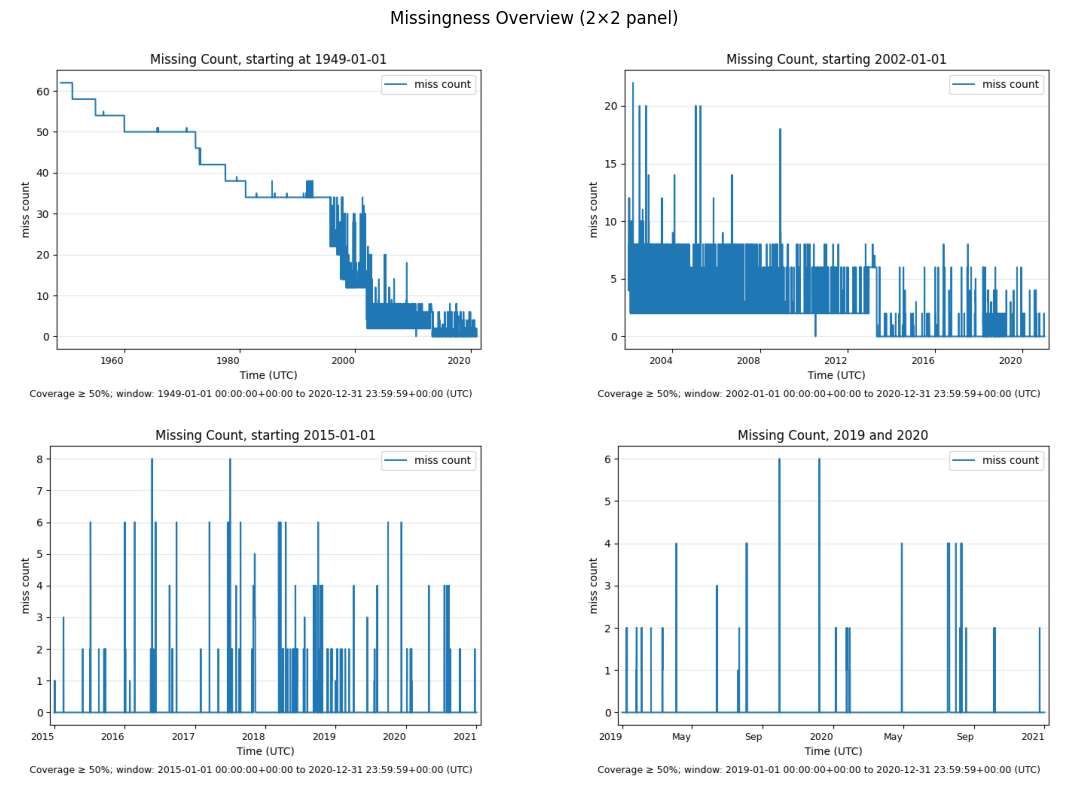

In [32]:
# Recreate the four figures exactly as before
fig1, ax1 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="1949-01-01 00:00",
    end_date="2020-12-31 23:59:59",
      column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count, starting at 1949-01-01",
)

fig2, ax2 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2002-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count, starting 2002-01-01",
)

fig3, ax3 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2015-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count, starting 2015-01-01",
)

fig4, ax4 = plotting_utils.plot_resampled(
    df=missingness_summary_df,
    start_date="2019-01-01 00:00",
    end_date="2020-12-31 23:59:59",
    column="miss_count",
    granularity="H",
    time_col="utc_timestamp",
    how="sum",
    coverage_threshold=0.5,
    title="Missing Count, 2019 and 2020",
)

# Convert each figure to an image
imgs = [plotting_utils.fig_to_rgb_array(f) for f in (fig1, fig2, fig3, fig4)]

# Compose into a 2×2 panel
panel_fig, axes = plt.subplots(2, 2, figsize=(12, 8), squeeze=False)
for i, img in enumerate(imgs):
    ax = axes[i // 2][i % 2]
    ax.imshow(img)
    ax.axis("off")

panel_fig.suptitle("Missingness Overview (2×2 panel)", y=0.98, fontsize=12)
panel_fig.tight_layout()

# (Optional) Close the originals to free memory
plt.close(fig1); plt.close(fig2); plt.close(fig3); plt.close(fig4)

plt.show()